In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
from google.colab import drive
drive.mount('/content/drive')

os.makedirs("./images/dcgan",exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE= 64
N_EPOCHS = 20
IMAGE_SIZE = 64
LATENT_DIM = 100
PRINT_EVERY = 5
N_SHOW = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [78]:
data = datasets.CIFAR10(root="./data",transform=transform,download=True)

In [80]:
iterator = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [81]:
class Discriminator(nn.Module):
  def __init__(self,image_size):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(
            in_channels=512,
            out_channels=1,
            kernel_size=4,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.main(x).view(-1, 1).squeeze(1)

In [82]:
class Generator(nn.Module):
  def __init__(self,latent_dim,image_size):
    super().__init__()

    self.main = nn.Sequential(
        nn.ConvTranspose2d(in_channels=latent_dim,
                               out_channels=image_size*8,
                               kernel_size=4,
                               stride=2,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*8,
                               out_channels=image_size*4,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*4,
                               out_channels=image_size*2,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size*2,
                               out_channels=image_size,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=image_size,
                               out_channels=3,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),

            nn.Tanh(),
    )
  def forward(self,x):
      x = self.main(x)
      return x

In [83]:
import pathlib

if pathlib.Path('generator.pth').exists():
    G = Generator(LATENT_DIM,IMAGE_SIZE).to(device)
    G.load_state_dict(torch.load('generator.pth'))
    print("Generator loaded")
else:
    G = Generator(LATENT_DIM,IMAGE_SIZE).to(device)
    print("Generator created")

if pathlib.Path('discriminator.pth').exists():
    D = Discriminator(IMAGE_SIZE).to(device)
    D.load_state_dict(torch.load('discriminator.pth'))
    print("Discriminator loaded")
else:
    D = Discriminator(IMAGE_SIZE).to(device)
    print("Discriminator created")

Generator created
Discriminator created


In [84]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [85]:
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [86]:
criterion = nn.BCELoss()

In [87]:
G_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))

In [88]:
real_labels = torch.ones(BATCH_SIZE).to(device)
fake_labels = torch.zeros(BATCH_SIZE).to(device)

| Epoch: 001 | D_error: 0.570 | G_error: 2.264 


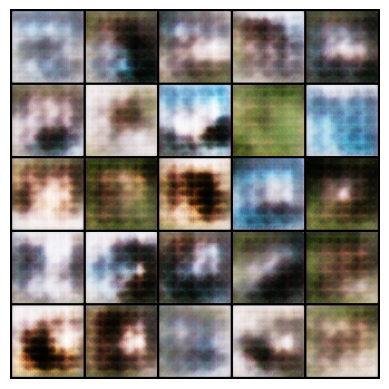

In [ ]:
for epoch in range(1, N_EPOCHS + 1):

    start_time = time.time()

    for _ in range(len(iterator)):

        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#

        D.zero_grad()

        x, _ = next(iter(iterator))
        x = x.to(device)

        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)

        with torch.no_grad():
            generated_images = G(z)

        pred_real = D(x)
        D_error_real = criterion(pred_real, real_labels)

        pred_fake = D(generated_images.detach())
        D_error_fake = criterion(pred_fake, fake_labels)

        D_error = D_error_real + D_error_fake
        D_error.backward()
        D_optimizer.step()

        #=================#
        # TRAIN GENERATOR #
        #=================#

        G.zero_grad()

        x, _ = next(iter(iterator))
        x = x.to(device)

        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        generated_images = G(z)

        pred_fake = D(generated_images)
        G_error = criterion(pred_fake, real_labels)

        G_error.backward()
        G_optimizer.step()

    end_time = time.time()

    # ✅ After all batches in the epoch are trained, show image
    z = torch.randn(N_SHOW * N_SHOW, LATENT_DIM, 1, 1).to(device)
    with torch.no_grad():
        generated_images = G(z)

    print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} ')

    # Save image grid
    save_path = f'images/dcgan/epoch{epoch:03}.png'
    torchvision.utils.save_image(
        generated_images,
        save_path,
        nrow=N_SHOW,
        normalize=True
    )

    # Show the image
    img = plt.imread(save_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [ ]:
# Save only weights (state_dict)
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')


Let's check if the directory exists and what's inside it. Please replace `"/content/drive/MyDrive/face_images"` with the actual path to your image folder if it's different.

In [ ]:
!ls "/content/drive/MyDrive/face_images"

ls: cannot access '/content/drive/MyDrive/face_images': No such file or directory
